In [3]:
# Importacion de librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import seaborn as sns

from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
%matplotlib inline

from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

,Sepal_length,Sepal_width,Petal_length,Petal_width
count,150.00,150.00,150.00,150.00
mean,5.84,3.06,3.76,1.20
std,0.83,0.44,1.77,0.76
min,4.30,2.00,1.00,0.10
25%,5.10,2.80,1.60,0.30
50%,5.80,3.00,4.35,1.30
75%,6.40,3.30,5.10,1.80
max,7.90,4.40,6.90,2.50


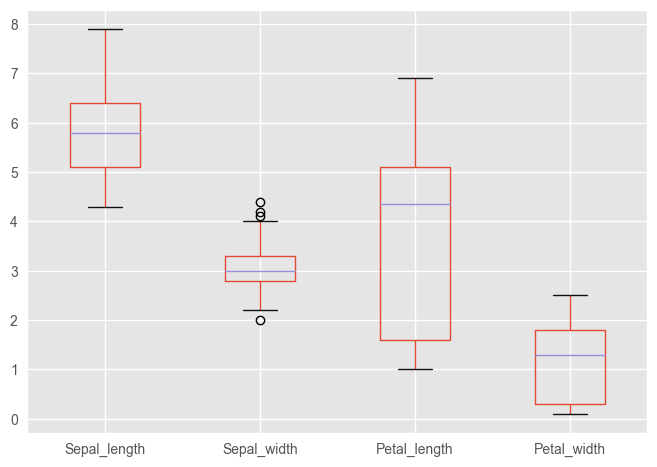

In [4]:
# Base de datos iris
iris = datasets.load_iris()

X = pd.DataFrame(iris.data)
y = iris.target

X.columns = ['Sepal_length', 'Sepal_width', 'Petal_length', 'Petal_width']

X.boxplot()
round(X.describe(),2)

,Sepal_length,Sepal_width,Petal_length,Petal_width
count,150.00,150.00,150.00,150.00
mean,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-1.87,-2.43,-1.57,-1.45
25%,-0.90,-0.59,-1.23,-1.18
50%,-0.05,-0.13,0.34,0.13
75%,0.67,0.56,0.76,0.79
max,2.49,3.09,1.79,1.71


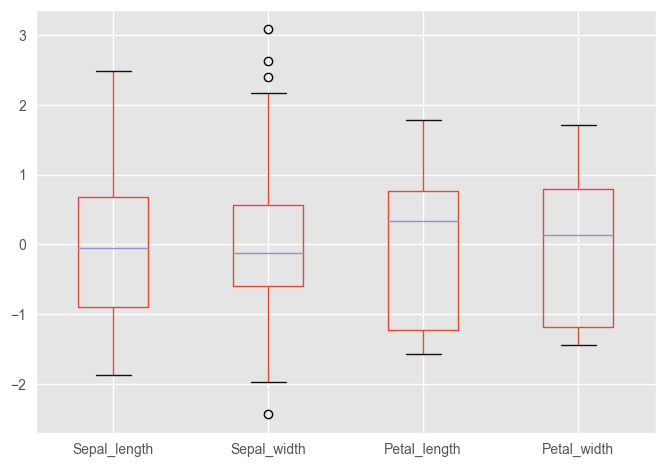

In [5]:
# Se recomienda escalar o estandarizar o bien usar una distancia ponderada.

X2 = pd.DataFrame(scale(X))
X2.columns = ['Sepal_length', 'Sepal_width', 'Petal_length', 'Petal_width']

X2.boxplot()
round(X2.describe(),2)

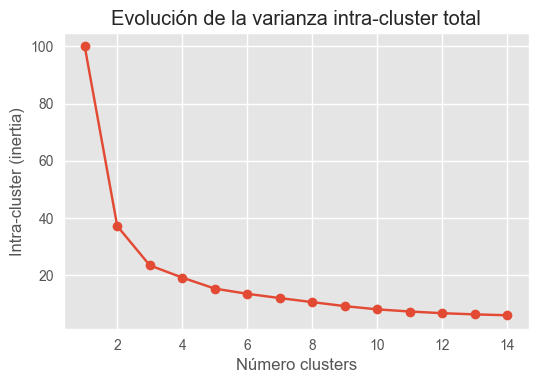

In [6]:
# Método del codo para identificar el número óptimo de clusters con Kmeans 
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 30, random_state=0
                    )
    modelo_kmeans.fit(X2)
    inertias.append(modelo_kmeans.inertia_)



fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, np.array(inertias)/600*100, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');


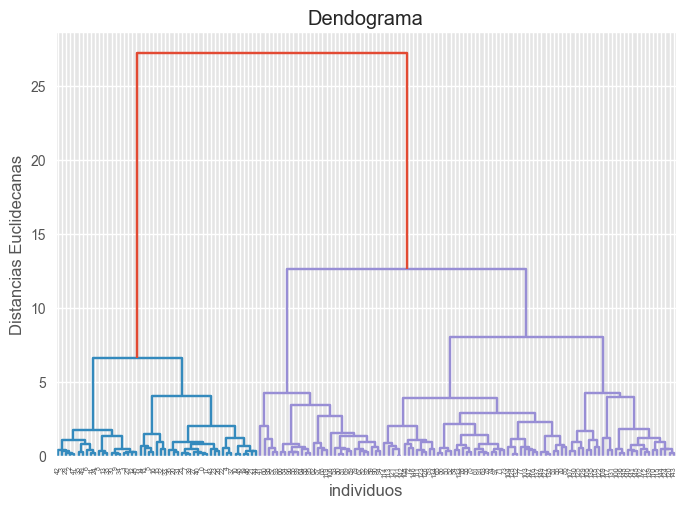

In [7]:
# Creamos el dendograma con el método de enlace ward
dendrogram = sch.dendrogram(sch.linkage(X2, method = 'ward'))

plt.title('Dendograma')
plt.xlabel('individuos')
plt.ylabel('Distancias Euclidecanas')
plt.show()

In [8]:
## Calcula de las suma intra 
def sum_intra(df_input, y_hc):
    DW = []
    for n_cluster in range(0, max(y_hc)+1):
        DW_aux = pairwise_distances(X=df_input[y_hc==n_cluster],  metric ='euclidean')
        DW.append(DW_aux.sum())
    return sum(DW)

In [13]:
## Ejemplo calculo suma intra usando algoritmo jerárquico
n_clusters = 30
hc = AgglomerativeClustering(n_clusters = n_clusters, 
                    metric = 'euclidean', 
                    linkage = 'ward')

y_hc = hc.fit_predict(X2)

ST = pairwise_distances(X=X2,  metric ='euclidean')

print(sum_intra(X2, y_hc))
print(ST.sum())

385.26801867457675
56097.086118931635


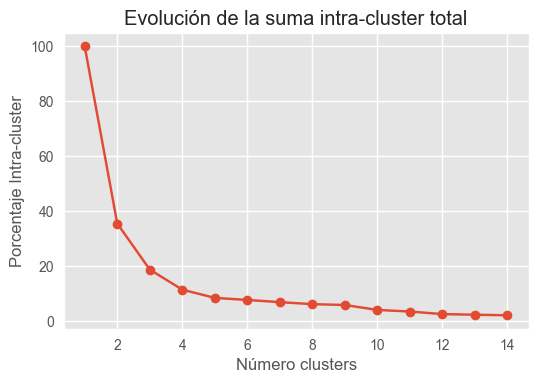

In [14]:
# Método del codo para identificar el número óptimo de clusters con métodos jerarquicos
# ==============================================================================
range_n_clusters = range(1, 15)
SW = []

for n_clusters in range_n_clusters:
    modelo_hc = AgglomerativeClustering(n_clusters = n_clusters, 
                    metric = 'euclidean', 
                    linkage = 'ward')
    y_hc = modelo_hc.fit_predict(X2)
    SW.append(sum_intra(X2, y_hc))
 
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, SW/SW[0]*100, marker='o')
ax.set_title("Evolución de la suma intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Porcentaje Intra-cluster');



In [15]:
SB=SW[0]-SW
SB

array([    0.        , 36112.54884391, 45518.90874448, 49609.99273766,
       51284.59021771, 51708.55705117, 52155.07947531, 52567.83209151,
       52735.11758536, 53744.79000747, 54068.4787624 , 54596.91136108,
       54725.40311484, 54836.05102813])

[267.43962872 316.27752821 372.17792904 386.29983979 339.34068119
 315.32909676 302.15337698 276.46197112 355.41021512 370.47674732
 456.57551996 455.48547586 454.91950334]


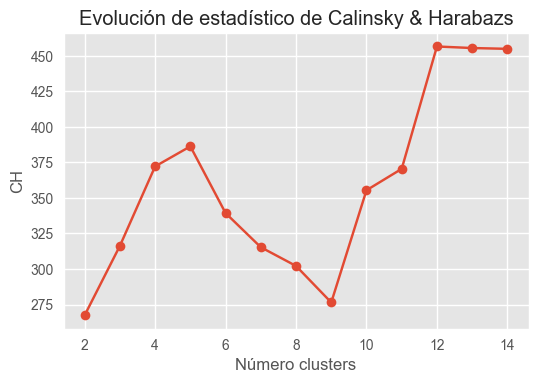

In [16]:
# Método de Calinsky & Harabazs
# Método Hartigan

SB=SW[0]-SW
K=np.arange(15)
CH=SB[1:14]/SW[1:14]*(150-K[2:15])/K[1:14]
print(CH)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range(2, 15), CH, marker='o')
ax.set_title("Evolución de estadístico de Calinsky & Harabazs")
ax.set_xlabel('Número clusters')
ax.set_ylabel('CH');

[0.01204683 0.00596794 0.00426115 0.00236713 0.0006617  0.00078119
 0.00081217 0.00034796 0.00302274 0.00113165 0.00251605 0.00067392
 0.00063582]


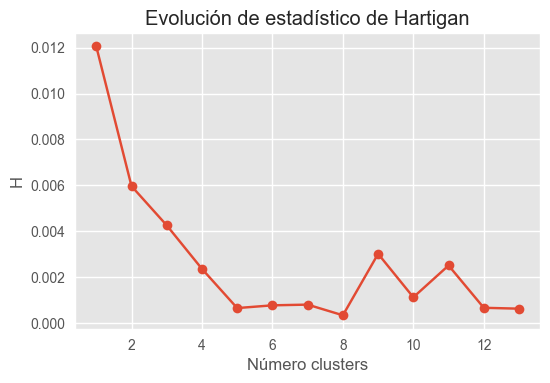

In [17]:
SW=np.array(SW)
H=(SW[0:13]/SW[1:14]-1)/(150-K[0:13])
print(H)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range(1, 14), H, marker='o')
ax.set_title("Evolución de estadístico de Hartigan")
ax.set_xlabel('Número clusters')
ax.set_ylabel('H');

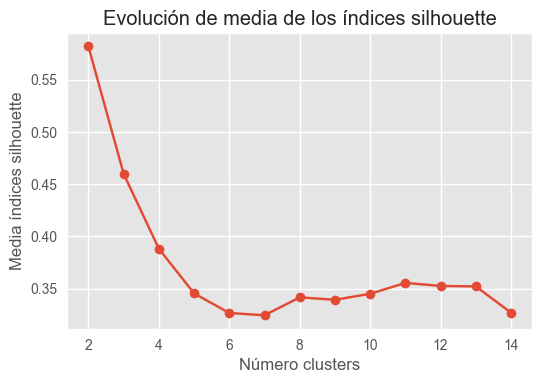

In [18]:
# Método silhouette para identificar el número óptimo de clusters con Kmeans
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 1
                    )
    cluster_labels = modelo_kmeans.fit_predict(X2)
    silhouette_avg = silhouette_score(X2, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [19]:
valores_medios_silhouette

[0.5817500491982808,
 0.45994823920518635,
 0.38822009621659853,
 0.3455109959980946,
 0.32674451109112396,
 0.3245614896948431,
 0.34174447510456185,
 0.33936599985839555,
 0.34517482794134624,
 0.35554009502677775,
 0.3526264876310143,
 0.35217601583457614,
 0.3269366880035856]

SilhouetteVisualizer(ax=<Axes: >, colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, n_init=20, random_state=0))

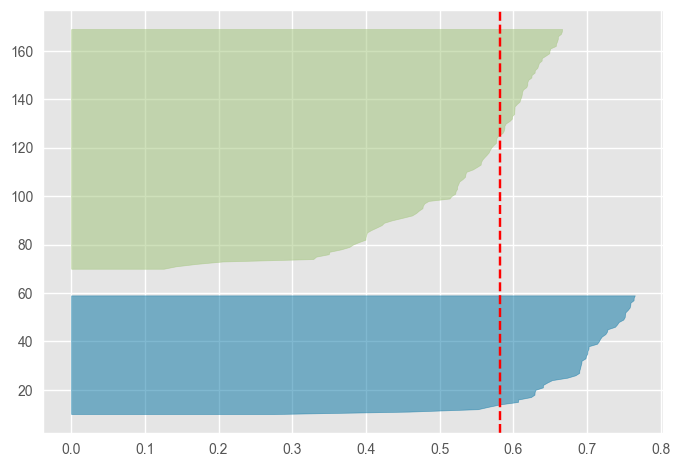

In [21]:
# Genero un modelo con K=2
# Ploteo el gráfico de silueta
visualizer = SilhouetteVisualizer(KMeans(2, n_init=20, random_state=0), colors='yellowbrick')    
visualizer.fit(X2)                                          

SilhouetteVisualizer(ax=<Axes: >, colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init=20, random_state=0))

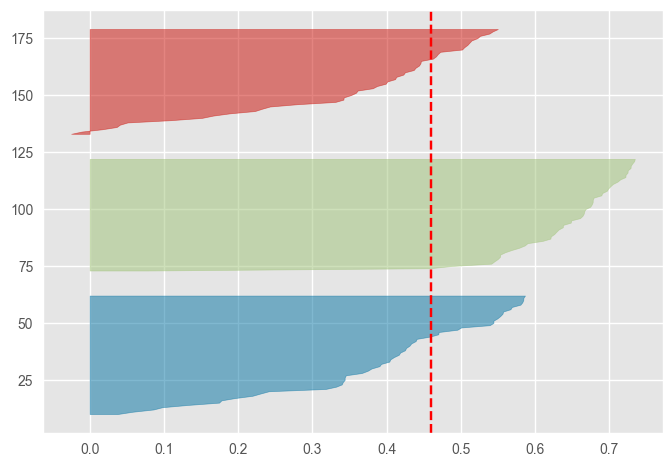

In [22]:
# Genero un modelo con K=3
# Ploteo el gráfico de silueta
visualizer = SilhouetteVisualizer(KMeans(3, n_init=20, random_state=0), colors='yellowbrick')    
visualizer.fit(X2)       

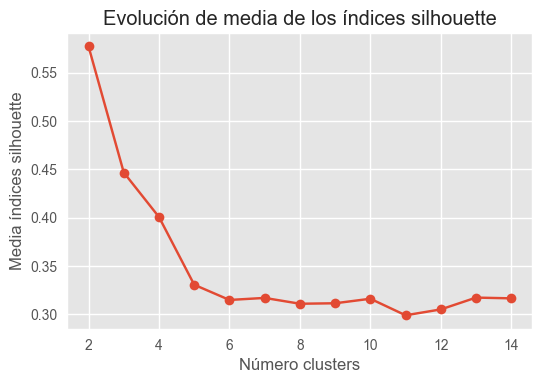

In [23]:
# Método silhouette para identificar el número óptimo de clusters Jerárquicos

range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
                    metric     = 'euclidean',
                    linkage    = 'ward',
                    n_clusters = n_clusters
             )

    cluster_labels = modelo.fit_predict(X2)
    silhouette_avg = silhouette_score(X2, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [ ]:
################################################
## Componentes principales

In [30]:
## De forma manual

# Calculamos la matriz de covarianza y correlacion
cov = X2.cov()
cor = X2.corr()
print(cov)
print(cor)
cov2 = X.cov()

              Sepal_length  Sepal_width  Petal_length  Petal_width
Sepal_length      1.006711    -0.118359      0.877604     0.823431
Sepal_width      -0.118359     1.006711     -0.431316    -0.368583
Petal_length      0.877604    -0.431316      1.006711     0.969328
Petal_width       0.823431    -0.368583      0.969328     1.006711
              Sepal_length  Sepal_width  Petal_length  Petal_width
Sepal_length      1.000000    -0.117570      0.871754     0.817941
Sepal_width      -0.117570     1.000000     -0.428440    -0.366126
Petal_length      0.871754    -0.428440      1.000000     0.962865
Petal_width       0.817941    -0.366126      0.962865     1.000000


In [28]:
print(cov*149/150)

              Sepal_length  Sepal_width  Petal_length  Petal_width
Sepal_length      1.000000    -0.117570      0.871754     0.817941
Sepal_width      -0.117570     1.000000     -0.428440    -0.366126
Petal_length      0.871754    -0.428440      1.000000     0.962865
Petal_width       0.817941    -0.366126      0.962865     1.000000


In [34]:
#Calculamos los autovalores y autovectores de la matriz y los mostramos
eig_vals, eig_vecs = np.linalg.eig(cov)
eig2_vals, eig2_vecs = np.linalg.eig(cor)
eig3_vals, eig3_vecs = np.linalg.eig(cov2)

print('Eigenvectors (Covarianza) \n%s' %eig_vecs)
print('\nEigenvalues (Covarianza) \n%s' %eig_vals)

print('\nEigenvectors (Correlación) \n%s' %eig2_vecs)
print('\nEigenvalues (Correlación) \n%s' %eig2_vals)



Eigenvectors (Covarianza) 
[[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]

Eigenvalues (Covarianza) 
[2.93808505 0.9201649  0.14774182 0.02085386]

Eigenvectors (Correlación) 
[[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]

Eigenvalues (Correlación) 
[2.91849782 0.91403047 0.14675688 0.02071484]


In [33]:

print('Eigenvectors (Covarianza Originales) \n%s' %eig3_vecs)
print('\nEigenvalues (Covarianza Originales) \n%s' %eig3_vals)

Eigenvectors (Covarianza Originales) 
[[ 0.36138659 -0.65658877 -0.58202985  0.31548719]
 [-0.08452251 -0.73016143  0.59791083 -0.3197231 ]
 [ 0.85667061  0.17337266  0.07623608 -0.47983899]
 [ 0.3582892   0.07548102  0.54583143  0.75365743]]

Eigenvalues (Covarianza Originales) 
[4.22824171 0.24267075 0.0782095  0.02383509]


In [35]:
# A partir de los autovalores de la covarianza, calculamos la varianza explicada
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print(tot)
print(var_exp)
print(cum_var_exp)

4.026845637583893
[72.96244541329986, 22.850761786701774, 3.668921889282877, 0.5178709107154863]
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [36]:
# A partir de los autovalores de la correlación, calculamos la varianza explicada
tot = sum(eig2_vals)
var_exp = [(i / tot)*100 for i in sorted(eig2_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print(tot)
print(var_exp)
print(cum_var_exp)

3.9999999999999996
[72.9624454132999, 22.85076178670176, 3.6689218892828697, 0.5178709107154722]
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [37]:
# A partir de los autovalores de la covarianza original, calculamos la varianza explicada
tot = sum(eig3_vals)
var_exp = [(i / tot)*100 for i in sorted(eig3_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print(tot)
print(var_exp)
print(cum_var_exp)

4.572957046979867
[92.46187232017269, 5.3066483117067875, 1.7102609807929727, 0.5212183873275312]
[ 92.46187232  97.76852063  99.47878161 100.        ]


In [38]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(X2)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = X2.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4']
)

,Sepal_length,Sepal_width,Petal_length,Petal_width
PC1,0.521066,-0.269347,0.580413,0.564857
PC2,0.377418,0.923296,0.024492,0.066942
PC3,-0.719566,0.244382,0.142126,0.634273
PC4,-0.261286,0.123510,0.801449,-0.523597


----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.72962445 0.22850762 0.03668922 0.00517871]


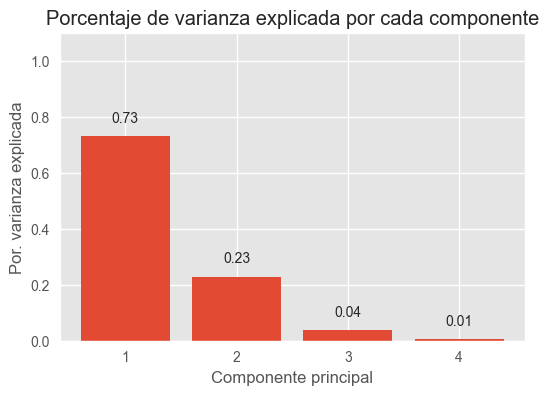

In [39]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(X2.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.72962445 0.95813207 0.99482129 1.        ]


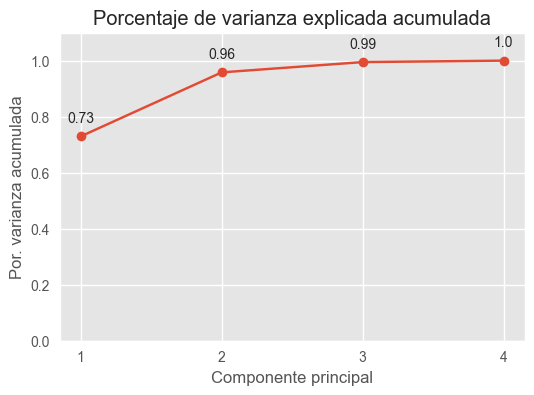

In [40]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(X2.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(X2.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

In [43]:
# Proyección de las observaciones de entrenamiento
# ==============================================================================
proyecciones = pca_pipe.transform(X=X2)
proyecciones = pd.DataFrame(
    proyecciones,
    columns = ['PC1', 'PC2', 'PC3', 'PC4'],
    index   = X2.index
)
proyecciones.head(10)

,PC1,PC2,PC3,PC4
0,-2.264703,0.480027,-0.127706,-0.024168
1,-2.080961,-0.674134,-0.234609,-0.103007
2,-2.364229,-0.341908,0.044201,-0.028377
3,-2.299384,-0.597395,0.091290,0.065956
4,-2.389842,0.646835,0.015738,0.035923
5,-2.075631,1.489178,0.026968,-0.006608
6,-2.444029,0.047644,0.335470,0.036776
7,-2.232847,0.223148,-0.088695,0.024612
8,-2.334640,-1.115328,0.145077,0.026859
9,-2.184328,-0.469014,-0.253766,0.039899


In [41]:
X2

,Sepal_length,Sepal_width,Petal_length,Petal_width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


cluster      0    1
grupo_real         
1.0         50  100


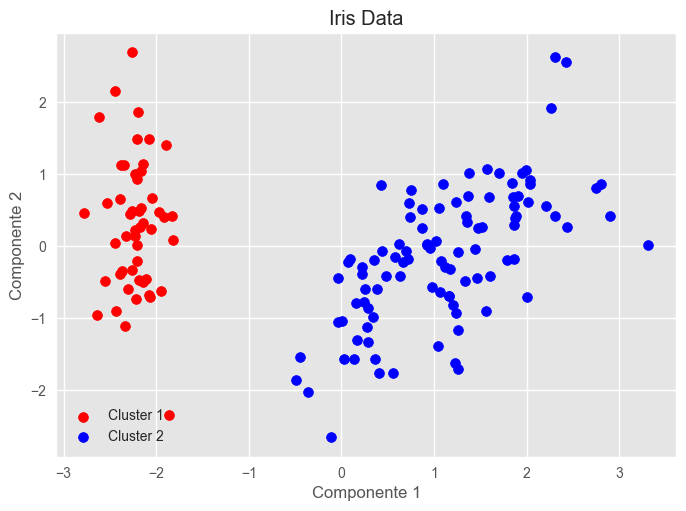

In [46]:
# Modelo KMeans 

modelo_kmeans = KMeans(n_clusters=2, n_init=25, random_state=0)
modelo_kmeans.fit(X=X2)

y_km = modelo_kmeans.predict(X=X2)

print(pd.crosstab(y, y_km, dropna=False, rownames=['grupo_real'], colnames=['cluster']))

# Visualizacion primeras 2 componentes principales 
plt.scatter(proyecciones['PC1'][y_km == 0], proyecciones['PC2'][y_km == 0], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(proyecciones['PC1'][y_km == 1], proyecciones['PC2'][y_km == 1], s = 50, c = 'blue', label = 'Cluster 2')
#plt.scatter(proyecciones['PC1'][y_km == 2], proyecciones['PC2'][y_km == 2], s = 50, c = 'green', label = 'Cluster 3')

plt.title('Iris Data')
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend()
plt.show()

In [47]:
X

,Sepal_length,Sepal_width,Petal_length,Petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


cluster      0    1
grupo_real         
1.0         50  100


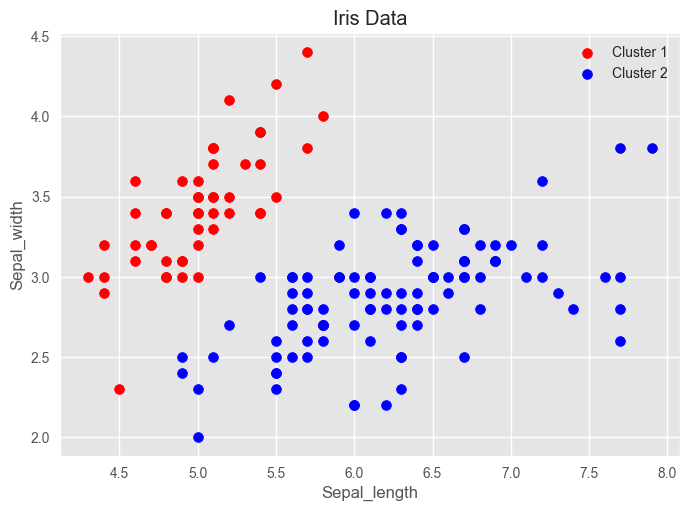

In [50]:
# Modelo KMeans 

modelo_kmeans = KMeans(n_clusters=2, n_init=25, random_state=0)
modelo_kmeans.fit(X=X2)

y_km = modelo_kmeans.predict(X=X2)

print(pd.crosstab(y, y_km, dropna=False, rownames=['grupo_real'], colnames=['cluster']))

# Visualizacion primeras 2 componentes principales 
plt.scatter(X['Sepal_length'][y_km == 0], X['Sepal_width'][y_km == 0], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X['Sepal_length'][y_km == 1], X['Sepal_width'][y_km == 1], s = 50, c = 'blue', label = 'Cluster 2')
#plt.scatter(proyecciones['PC1'][y_km == 2], proyecciones['PC2'][y_km == 2], s = 50, c = 'green', label = 'Cluster 3')

plt.title('Iris Data')
plt.xlabel("Sepal_length")
plt.ylabel("Sepal_width")
plt.legend()
plt.show()

In [54]:
proyecciones[['PC1','PC2']]

,PC1,PC2
0,-2.264703,0.480027
1,-2.080961,-0.674134
2,-2.364229,-0.341908
3,-2.299384,-0.597395
4,-2.389842,0.646835
...,...,...
145,1.870503,0.386966
146,1.564580,-0.896687
147,1.521170,0.269069
148,1.372788,1.011254


cluster      0   1   2
grupo_real            
1.0         50  53  47


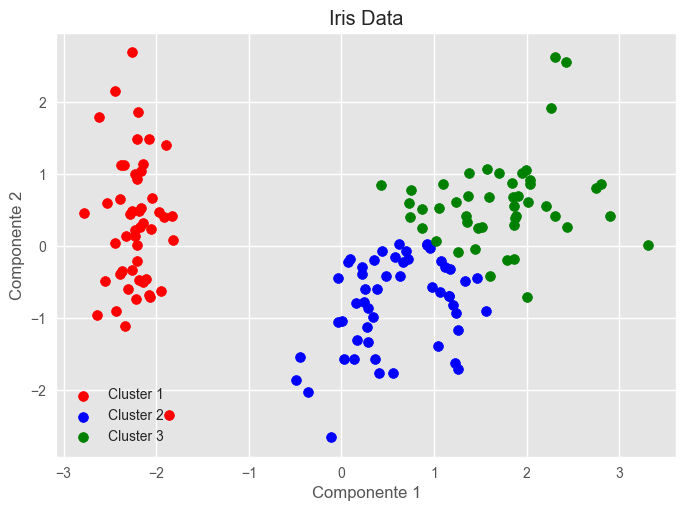

In [62]:
# Modelo KMeans 

modelo_kmeans = KMeans(n_clusters=3, n_init=25, random_state=0)
#modelo_kmeans.fit(X=X2)
modelo_kmeans.fit(X=proyecciones[['PC1','PC2']])

y_km = modelo_kmeans.predict(X=proyecciones[['PC1','PC2']])

print(pd.crosstab(y, y_km, dropna=False, rownames=['grupo_real'], colnames=['cluster']))

# Visualizacion primeras 2 componentes principales 
plt.scatter(proyecciones['PC1'][y_km == 0], proyecciones['PC2'][y_km == 0], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(proyecciones['PC1'][y_km == 1], proyecciones['PC2'][y_km == 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(proyecciones['PC1'][y_km == 2], proyecciones['PC2'][y_km == 2], s = 50, c = 'green', label = 'Cluster 3')

plt.title('Iris Data')
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend()
plt.show()

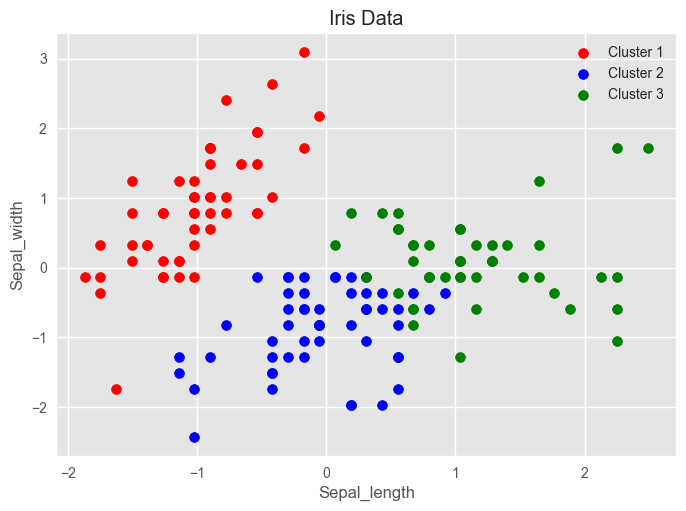

In [56]:
# Visualizacion dos variables

#'Sepal_length', 'Sepal_width', 'Petal_length', 'Petal_width']
plt.scatter(X2['Sepal_length'][y_km == 0], X2['Sepal_width'][y_km == 0], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(X2['Sepal_length'][y_km == 1], X2['Sepal_width'][y_km == 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(X2['Sepal_length'][y_km == 2], X2['Sepal_width'][y_km == 2], s = 50, c = 'green', label = 'Cluster 3')

plt.title('Iris Data')
plt.xlabel("Sepal_length")
plt.ylabel("Sepal_width")
plt.legend()
plt.show()

In [60]:
## Utilizar el modelo para agrupar item nuevos

new_df = pd.DataFrame()

# Incluyendo datos alaeatorios 
import random
from math import sqrt

nums1=[]
nums2=[]
nums3=[]
nums4=[]
for i in range(5): 
    nums1.append(round(random.gauss(X['Sepal_length'].mean(), X['Sepal_length'].std()/sqrt(1)),2)) 
    nums2.append(round(random.gauss(X['Sepal_width'].mean(), X['Sepal_width'].std()/sqrt(5)),2)) 
    nums3.append(round(random.gauss(X['Petal_length'].mean(), X['Petal_length'].std()/sqrt(2)),2)) 
    nums4.append(round(random.gauss(X['Petal_width'].mean(), X['Petal_width'].std()/sqrt(5)),2)) 

new_df['Sepal_length'] = nums1
new_df['Sepal_width'] = nums2
new_df['Petal_length'] = nums3
new_df['Petal_width'] = nums4
print(new_df)

# estandarización de las nuevas observaciones
new_df2 = (new_df-X.mean())/X.std()
print(new_df2)

# Transformación de las nuevas observaciones
new_proyecciones = pca_pipe.transform(X=new_df2)
new_proyecciones = pd.DataFrame(
    new_proyecciones,
    columns = ['PC1', 'PC2', 'PC3', 'PC4'],
    index   = new_df2.index
)
new_proyecciones.head(10)

   Sepal_length  Sepal_width  Petal_length  Petal_width
0          5.34         3.30          3.84         1.58
1          5.22         3.24          2.26         1.47
2          5.44         3.16          6.67         1.00
3          5.67         3.38          3.39         0.92
4          6.93         3.13          3.51         0.94
   Sepal_length  Sepal_width  Petal_length  Petal_width
0     -0.607842     0.556746      0.046451     0.499407
1     -0.752758     0.419089     -0.848582     0.355095
2     -0.487079     0.235546      1.649580    -0.261511
3     -0.209323     0.740288     -0.208463    -0.366465
4      1.312295     0.166718     -0.140486    -0.340226


,PC1,PC2,PC3,PC4
0,-0.157630,0.319200,0.896803,0.003324
1,-0.797067,0.105826,0.748698,-0.617575
2,0.492478,0.056542,0.476628,1.615340
3,-0.636461,0.574865,0.069468,0.170933
4,0.365168,0.622997,-1.139303,-0.256744


In [64]:
# predicciones de las nuevas observaciones
modelo_kmeans.predict(X=new_proyecciones[['PC1','PC2']])

array([1, 0, 1, 0, 2], dtype=int32)

In [106]:
from sklearn_extra.cluster import KMedoids

KMobj = KMedoids(n_clusters=3).fit(X2)
y_KMD = KMobj.labels_
print(y_KMD)


pd.crosstab(y, y_KMD, dropna=False, rownames=['grupo_real'], colnames=['cluster'])

# Visualizacion primeras 2 componentes principales 

plt.scatter(proyecciones['PC1'][y_KMD == 0], proyecciones['PC2'][y_KMD == 0], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(proyecciones['PC1'][y_KMD == 1], proyecciones['PC2'][y_KMD == 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(proyecciones['PC1'][y_KMD == 2], proyecciones['PC2'][y_KMD == 2], s = 50, c = 'green', label = 'Cluster 3')

plt.title('Iris Data')
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'sklearn_extra'

In [106]:
from sklearn_extra.cluster import KMedoids

KMobj = KMedoids(n_clusters=3).fit(X2)
y_KMD = KMobj.labels_
print(y_KMD)


pd.crosstab(y, y_KMD, dropna=False, rownames=['grupo_real'], colnames=['cluster'])

# Visualizacion primeras 2 componentes principales 

plt.scatter(proyecciones['PC1'][y_KMD == 0], proyecciones['PC2'][y_KMD == 0], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(proyecciones['PC1'][y_KMD == 1], proyecciones['PC2'][y_KMD == 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(proyecciones['PC1'][y_KMD == 2], proyecciones['PC2'][y_KMD == 2], s = 50, c = 'green', label = 'Cluster 3')

plt.title('Iris Data')
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'sklearn_extra'